# LDA (Latent Dirichlet Allocation) for Topic Modeling - Problem 2

- **Each comment as a document**: each row of the dataframe only contains single comment from one person. 
- In this case, there are 129813 documents in total, which is a large data size, thus I used the **'online'** learning method here.

The reason of choosing **'online'** method is shown below:

**learning_method** : ‘batch’ | ‘online’, default=’batch’
- Method used to update `_component`. Only used in fit method. 
- In general, if the data size is **large**, the **'online'** update will be much faster than the batch update.
- **'batch'**: Batch variational Bayes method. Use all training data in
    each EM update.
    Old `components_` will be overwritten in each iteration.
- **'online'**: Online variational Bayes method. In each EM update, use
    mini-batch of training data to update the ``components_``
    variable incrementally. The learning rate is controlled by the
    ``learning_decay`` and the ``learning_offset`` parameters.

<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import spacy
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored, cprint
import joblib

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.spatial.distance import pdist
from ipywidgets import interact, FloatSlider

In [5]:
from pathlib import Path
import os

In [6]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,10)
pyLDAvis.enable_notebook()
pd.options.display.float_format = '{:,.2f}'.format

## 1. Load Data & Construct Dataframe

In [7]:
os.getcwd()

'D:\\Uchicago_Courses\\[!] FINM33165 - Probabilistic Programming and Deep Learning (Niels O Nygaard)\\HW2'

In [8]:
path = Path(os.getcwd())
data_path = path/'data_parsed'
data_path

WindowsPath('D:/Uchicago_Courses/[!] FINM33165 - Probabilistic Programming and Deep Learning (Niels O Nygaard)/HW2/data_parsed')

In [9]:
# folder names
os.listdir(path=data_path)[:10]

['A', 'AAC', 'AAIGF', 'AAP', 'AAUKF', 'AAXN', 'ABDC', 'ABEO', 'ABEV', 'ABM']

In [10]:
files = data_path.glob(r'**/contents.csv')
df = pd.DataFrame(columns=['speaker','content'])
for file in files:
    comments = pd.read_csv(file)
    #print(len(comments))
    df = df.append(comments)

docs = df[df['content'].notnull()].drop('speaker', axis=1)
docs.columns = ['article']

In [11]:
docs.head()

,article
0,"Thank you, Mike, and welcome, everyone, to Agi..."
1,"You can find the press release, investor prese..."
2,We will also make forward-looking statements a...
3,And now I would like to turn the call over to ...
4,"Thanks, Ankur, and thanks, everyone, for joini..."


In [12]:
n_docs = len(docs)
n_docs

129813

In [13]:
docs.iloc[0]['article']

"Thank you, Mike, and welcome, everyone, to Agilent's third quarter conference call for fiscal year 2019. With me are Mike McMullen, Agilent's President and CEO; and Bob McMahon, Agilent's Senior Vice President and CFO. Joining in the Q&A after Bob's comments will be Jacob Thaysen, President of Agilent's Life Science and Applied Markets Group; Sam Raha, President of Agilent's Diagnostics and Genomics Group; and Mark Doak, President of Agilent's CrossLab Group."

## Vectorizer & DTM

In [14]:
train_docs, test_docs = train_test_split(docs, 
                                         test_size=5000, 
                                         random_state=42)

In [15]:
train_docs.shape, test_docs.shape

((124813, 1), (5000, 1))

In [16]:
vectorizer = CountVectorizer(max_df=.2, min_df=20, stop_words='english',
                             binary='False', ngram_range=(1,1) )   # only include single tokens

In [17]:
train_dtm = vectorizer.fit_transform(train_docs['article'])

In [18]:
len(vectorizer.vocabulary_)

8884

In [19]:
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
words = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count, index=tokens).sort_values(ascending=False)

In [20]:
word_count.head(10)

just        18876
think       18777
million     17415
second      15807
business    15677
growth      14341
ve          14231
new         12975
going       12934
2019        12571
dtype: int64

In [21]:
train_dtm

<124813x8884 sparse matrix of type '<class 'numpy.int64'>'
	with 2906251 stored elements in Compressed Sparse Row format>

In [22]:
test_dtm = vectorizer.transform(test_docs['article'])

In [23]:
test_dtm

<5000x8884 sparse matrix of type '<class 'numpy.int64'>'
	with 117195 stored elements in Compressed Sparse Row format>

## 2. Use 5 Topics

### lda_opt model with 'online' method (5)

In [50]:
n_components = 5

In [51]:
lda_opt = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'online',
                                     max_iter = 100,   
                                     evaluate_every = 10,
                                     verbose = 1,
                                     random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 2033.7971
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 2030.7864
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 2028.5950
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [52]:
topics_count = lda_opt.components_

In [53]:
topics_count.shape

(5, 8884)

In [54]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)
topics_prob

array([[5.64471494e-04, 5.42647705e-03, 3.36122588e-04, ...,
        3.26245390e-07, 3.25133172e-07, 3.16578134e-07],
       [3.88967525e-07, 3.98016475e-07, 3.90947521e-07, ...,
        4.03882232e-07, 5.81080173e-05, 4.08745797e-07],
       [2.86996864e-07, 2.96432882e-07, 2.89577932e-07, ...,
        2.97461600e-07, 2.92615922e-07, 3.17378888e-07],
       [2.87559441e-07, 4.31102899e-04, 2.90276098e-07, ...,
        2.97304982e-07, 2.94114139e-07, 4.36866937e-05],
       [5.55393434e-07, 5.54551991e-07, 5.95634644e-07, ...,
        2.40208899e-04, 5.53432686e-07, 5.91452355e-07]])

In [55]:
topic_labels = ['Topic {}'.format(i) for i in range(1,n_components+1)]
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
00,0.00,0.00,0.00,0.00,0.00
000,0.01,0.00,0.00,0.00,0.00
01,0.00,0.00,0.00,0.00,0.00
02,0.00,0.00,0.00,0.00,0.00
022,0.00,0.00,0.00,0.00,0.00


In [56]:
# compute the words with the 20 highest probabilities in each topic
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(20).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,million,growth,new,just,thank
1,2019,market,continue,think,results
2,second,business,customers,going,good
3,revenue,second,business,ve,today
4,cash,sales,believe,really,questions
5,compared,strong,growth,yes,morning
6,net,expect,product,question,turn
7,2018,markets,team,right,forward
8,increase,demand,customer,like,financial
9,total,new,value,okay,thanks


### Topics Distributions & Heatmap (5)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


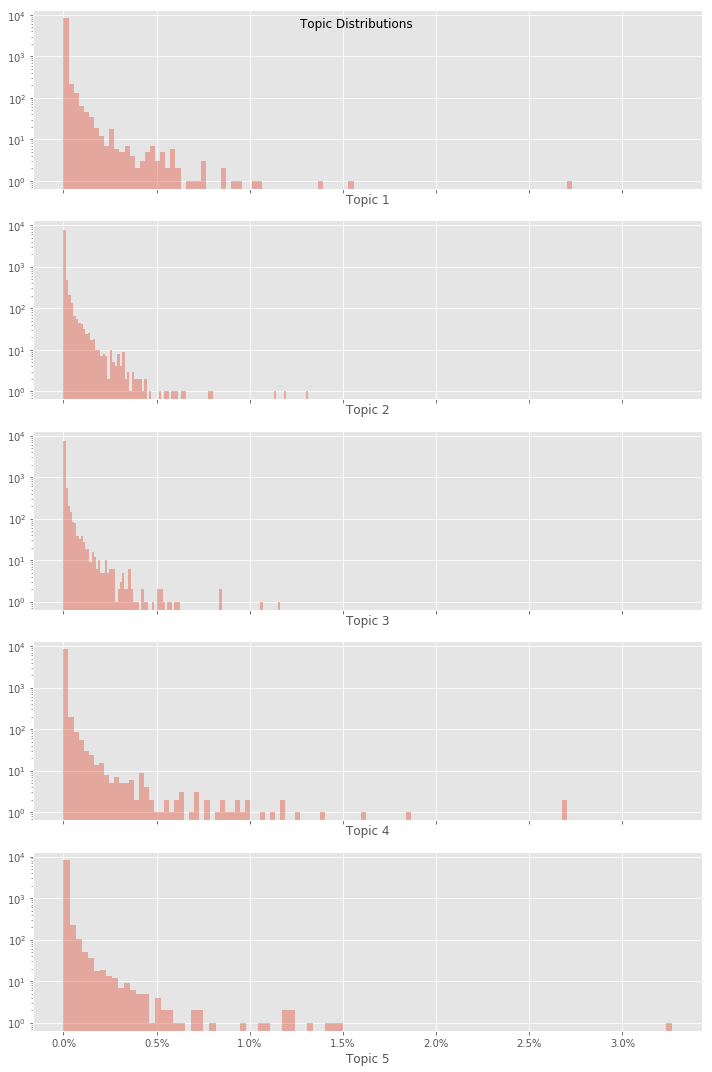

In [57]:
fig, axes = plt.subplots(nrows=n_components,sharey=True,sharex=True,figsize=(10,15))

for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob,ax=axes[i],bins=100,kde=False,norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x,_:'{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

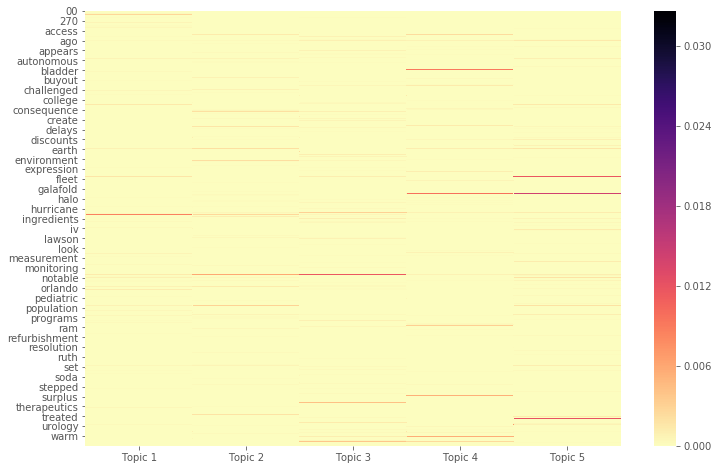

In [58]:
plt.figure(figsize=(12,8))
sns.heatmap(topics, cmap='magma_r');

### Word Cloud (5)

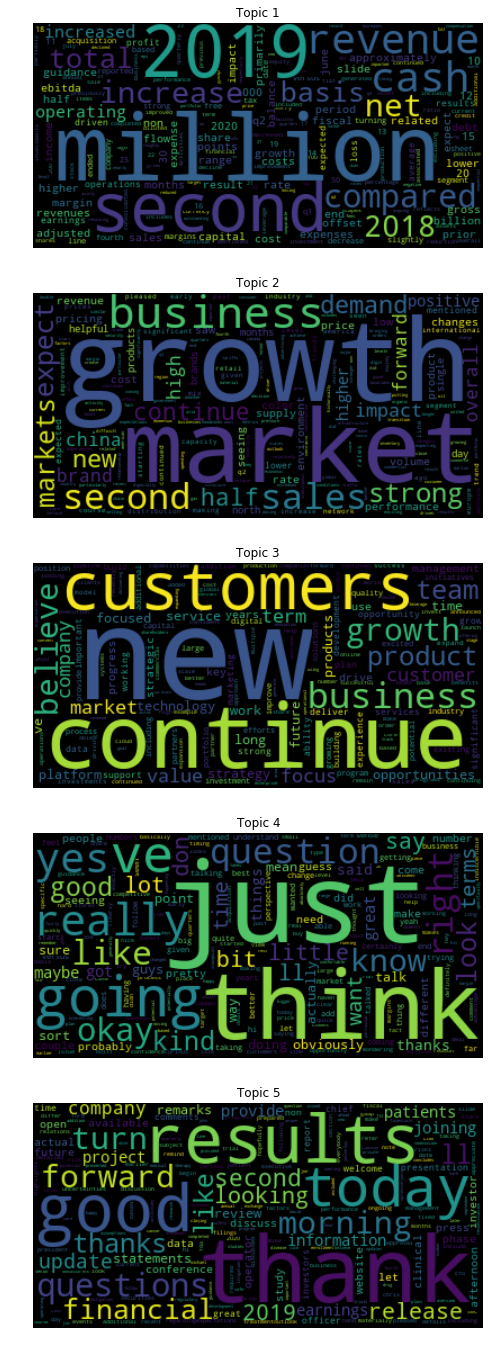

In [59]:
w = WordCloud()
fig, axes = plt.subplots(nrows= n_components, figsize=(12,24))
axes = axes.flatten()
for t,(topic,freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w,interpolation='bilinear')
    axes[t].set_title(topic, fontsize=12)
    axes[t].axis('off')

### Predictions (5)

In [60]:
train_preds = lda_opt.transform(train_dtm)
train_preds.shape

(124813, 5)

In [61]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels)

In [62]:
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,0.40,0.07,0.07,0.07,0.40
1,0.09,0.19,0.06,0.46,0.20
2,0.81,0.17,0.01,0.01,0.01
3,0.01,0.01,0.59,0.38,0.01
4,0.01,0.62,0.01,0.35,0.01


In [63]:
test_preds = lda_opt.transform(test_dtm)
test_preds.shape

(5000, 5)

In [64]:
test_eval = pd.DataFrame(test_preds, columns=topic_labels)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,0.12,0.01,0.45,0.37,0.05
1,0.29,0.31,0.01,0.34,0.06
2,0.29,0.09,0.34,0.17,0.12
3,0.01,0.32,0.29,0.38,0.01
4,0.06,0.09,0.37,0.46,0.01


### Perplexity (5)

In [65]:
lda_opt.perplexity(train_dtm)

2024.5733204419676

In [66]:
lda_opt.perplexity(test_dtm)

3689.735044391262

### Cluster Graphs using PyLDAvis.prepare (5)

In [67]:
prepare(lda_opt, test_dtm, vectorizer)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
2      0.06 -0.14       1        1 24.57
3     -0.18 -0.25       2        1 23.75
0      0.19  0.12       3        1 21.73
1      0.18  0.02       4        1 17.58
4     -0.26  0.25       5        1 12.37, topic_info=     Category   Freq          Term  Total  loglift  logprob
4517  Default 752.00          just 752.00    30.00    30.00
8088  Default 748.00         think 748.00    29.00    29.00
5163  Default 695.00       million 695.00    28.00    28.00
8065  Default 473.00         thank 473.00    27.00    27.00
3733  Default 515.00         going 515.00    26.00    26.00
6539  Default 386.00        really 386.00    25.00    25.00
3740  Default 481.00          good 481.00    24.00    24.00
147   Default 501.00          2019 501.00    23.00    23.00
8857  Default 349.00           yes 349.00    22.00    22.00
8550  Default 571.00            ve 571.00    21.00    21.00
6978  Default 326.00         right 326.00    20.00    20.00
4810  Default 387.00            ll 387.00    19.00    19.00
4752  Default 471.00          like 471.00    18.00    18.00
5547  Default 294.00          okay 294.00    17.00    17.00
7187  Default 631.00        second 631.00    16.00    16.00
6427  Default 345.00      question 345.00    15.00    15.00
6429  Default 193.00     questions 193.00    14.00    14.00
8158  Default 296.00         today 296.00    13.00    13.00
8068  Default 338.00        thanks 338.00    12.00    12.00
1536  Default 262.00          cash 262.00    11.00    11.00
4570  Default 277.00          know 277.00    10.00    10.00
6914  Default 353.00       results 353.00     9.00     9.00
4554  Default 263.00          kind 263.00     8.00     8.00
5263  Default 178.00       morning 178.00     7.00     7.00
4800  Default 258.00        little 258.00     6.00     6.00
1895  Default 242.00      compared 242.00     5.00     5.00
8336  Default 176.00          turn 176.00     4.00     4.00
1206  Default 253.00           bit 253.00     3.00     3.00
5382  Default 234.00           net 234.00     2.00     2.00
4860  Default 243.00           lot 243.00     1.00     1.00
...       ...    ...           ...    ...      ...      ...
5940   Topic5  62.20         phase  62.24     2.09    -5.45
2632   Topic5  59.65       discuss  59.69     2.09    -5.49
1754   Topic5  59.07      clinical  59.10     2.09    -5.50
586    Topic5  58.52     afternoon  58.55     2.09    -5.51
478    Topic5  56.63        actual  56.66     2.09    -5.55
4398   Topic5  56.18      investor  56.21     2.09    -5.55
8718   Topic5  55.61       website  55.65     2.09    -5.56
7772   Topic5  54.47         study  54.50     2.09    -5.58
6156   Topic5  53.34  presentation  53.38     2.09    -5.61
1669   Topic5  51.13         chief  51.16     2.09    -5.65
5528   Topic5  50.60       officer  50.63     2.09    -5.66
8733   Topic5  49.25       welcome  49.28     2.09    -5.68
4399   Topic5  47.45     investors  47.48     2.09    -5.72
5012   Topic5  44.68    materially  44.71     2.09    -5.78
8158   Topic5 204.47         today 296.46     1.72    -4.26
3392   Topic5 171.70     financial 247.48     1.72    -4.44
6914   Topic5 215.25       results 353.62     1.59    -4.21
3528   Topic5 175.07       forward 318.22     1.49    -4.42
3740   Topic5 208.48          good 481.99     1.25    -4.24
8068   Topic5 159.11        thanks 338.10     1.34    -4.51
4810   Topic5 152.85            ll 387.07     1.16    -4.55
4752   Topic5 140.97          like 471.23     0.88    -4.63
4850   Topic5 106.06       looking 265.44     1.17    -4.92
6330   Topic5  82.03       provide 168.00     1.37    -5.17
7187   Topic5 114.66        second 631.30     0.38    -4.84
147    Topic5 106.47          2019 501.59     0.54    -4.91
1887   Topic5  93.52       company 314.33     0.88    -5.04
2827   Topic5  75.32      earnings 158.02     1.35    -5.26
5579   Topic5  65.37          open  91.23     1.76    -5.40
1012   Top

## 3. Use 4 Topics

### lda_opt model with 'online' method (4)

In [68]:
n_components = 4

In [ ]:
lda_opt = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'online',
                                     max_iter = 100,
                                     evaluate_every=10,
                                     verbose = 1,
                                     random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 1938.6596
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 1932.4780
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 1930.0162
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=4, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [ ]:
topics_count = lda_opt.components_

In [ ]:
topics_count.shape

(4, 8884)

In [ ]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)
topics_prob

array([[4.87638265e-04, 4.22846414e-03, 2.90405721e-04, ...,
        3.75439533e-07, 3.69253830e-07, 3.40705900e-07],
       [8.17362589e-07, 7.97456013e-07, 7.97025976e-07, ...,
        8.12736605e-07, 9.28143011e-05, 6.47869069e-06],
       [2.48198650e-07, 6.27076091e-04, 2.70873716e-07, ...,
        8.65469886e-05, 3.16218471e-07, 1.91717762e-05],
       [3.00705634e-07, 2.58170906e-06, 3.06416526e-07, ...,
        3.65164992e-07, 4.18608128e-07, 1.13162679e-05]])

In [ ]:
topic_labels = ['Topic {}'.format(i) for i in range(1,n_components+1)]
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4
00,0.00,0.00,0.00,0.00
000,0.00,0.00,0.00,0.00
01,0.00,0.00,0.00,0.00
02,0.00,0.00,0.00,0.00
022,0.00,0.00,0.00,0.00


In [ ]:
# compute the words with the 20 highest probabilities in each topic
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(20).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4
0,million,thank,new,just
1,2019,thanks,continue,think
2,second,good,business,going
3,revenue,today,growth,ve
4,cash,results,market,really
5,compared,forward,customers,yes
6,increase,questions,product,right
7,net,morning,believe,question
8,2018,turn,products,like
9,growth,financial,customer,know


### Topics Distributions & Heatmap (4)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


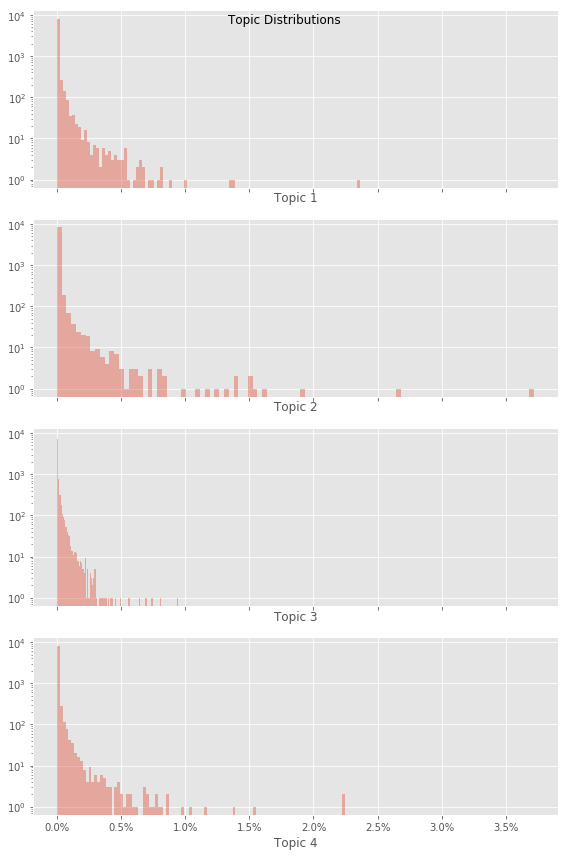

In [ ]:
fig, axes = plt.subplots(nrows=n_components,sharey=True,sharex=True,figsize=(8,12))

for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob,ax=axes[i],bins=100,kde=False,norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x,_:'{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

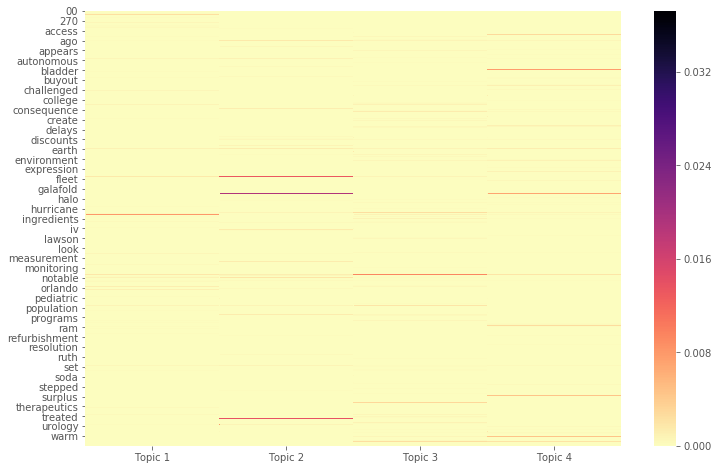

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(topics, cmap='magma_r');

### Word Cloud (4)

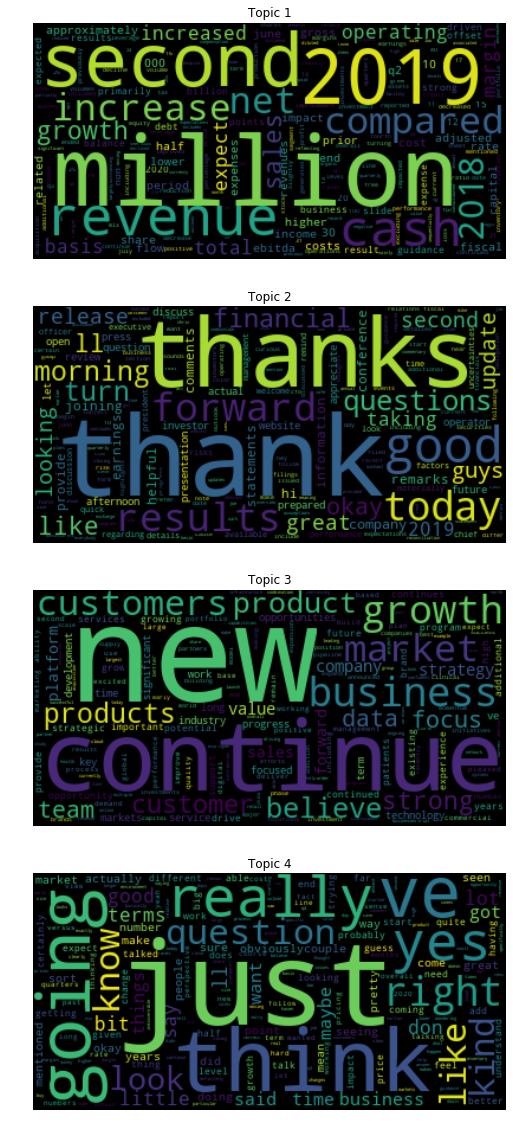

In [ ]:
w = WordCloud()
fig, axes = plt.subplots(nrows= n_components, figsize=(10,20))
axes = axes.flatten()
for t,(topic,freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w,interpolation='bilinear')
    axes[t].set_title(topic, fontsize=12)
    axes[t].axis('off')

### Predictions (4)

In [ ]:
train_preds = lda_opt.transform(train_dtm)
train_preds.shape

(124813, 4)

In [ ]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels)

In [ ]:
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4
0,0.42,0.42,0.08,0.08
1,0.09,0.43,0.10,0.38
2,0.92,0.01,0.06,0.01
3,0.01,0.08,0.49,0.41
4,0.06,0.01,0.16,0.76


In [ ]:
test_preds = lda_opt.transform(test_dtm)
test_preds.shape

(5000, 4)

In [ ]:
test_eval = pd.DataFrame(test_preds, columns=topic_labels)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4
0,0.14,0.01,0.36,0.49
1,0.25,0.01,0.08,0.66
2,0.38,0.01,0.32,0.28
3,0.01,0.07,0.34,0.58
4,0.12,0.01,0.32,0.54


### Perplexity (4)

In [ ]:
lda_opt.perplexity(train_dtm)

1925.4984424046224

In [ ]:
lda_opt.perplexity(test_dtm)

3353.9021855290584

### Cluster Graphs using PyLDAvis.prepare (4)

In [ ]:
prepare(lda_opt, test_dtm, vectorizer)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
2     -0.11 -0.03       1        1 35.47
3     -0.13 -0.22       2        1 28.66
0     -0.11  0.25       3        1 24.92
1      0.35 -0.00       4        1 10.95, topic_info=     Category   Freq          Term  Total  loglift  logprob
8065  Default 477.00         thank 477.00    30.00    30.00
5163  Default 689.00       million 689.00    29.00    29.00
4517  Default 753.00          just 753.00    28.00    28.00
8088  Default 749.00         think 749.00    27.00    27.00
8068  Default 339.00        thanks 339.00    26.00    26.00
3740  Default 484.00          good 484.00    25.00    25.00
3733  Default 516.00         going 516.00    24.00    24.00
147   Default 498.00          2019 498.00    23.00    23.00
3528  Default 320.00       forward 320.00    22.00    22.00
6539  Default 386.00        really 386.00    21.00    21.00
4810  Default 388.00            ll 388.00    20.00    20.00
8158  Default 298.00         today 298.00    19.00    19.00
6914  Default 355.00       results 355.00    18.00    18.00
4752  Default 473.00          like 473.00    17.00    17.00
8550  Default 571.00            ve 571.00    16.00    16.00
8857  Default 350.00           yes 350.00    15.00    15.00
6429  Default 195.00     questions 195.00    14.00    14.00
6978  Default 327.00         right 327.00    13.00    13.00
5263  Default 179.00       morning 179.00    12.00    12.00
8336  Default 177.00          turn 177.00    11.00    11.00
5547  Default 295.00          okay 295.00    10.00    10.00
3392  Default 248.00     financial 248.00     9.00     9.00
1536  Default 260.00          cash 260.00     8.00     8.00
7187  Default 630.00        second 630.00     7.00     7.00
4570  Default 278.00          know 278.00     6.00     6.00
1895  Default 240.00      compared 240.00     5.00     5.00
4554  Default 264.00          kind 264.00     4.00     4.00
6427  Default 346.00      question 346.00     3.00     3.00
4800  Default 259.00        little 259.00     2.00     2.00
5382  Default 232.00           net 232.00     1.00     1.00
...       ...    ...           ...    ...      ...      ...
3922   Topic4  66.37       helpful  66.40     2.21    -5.26
6167   Topic4  63.18         press  63.21     2.21    -5.31
586    Topic4  59.06     afternoon  59.09     2.21    -5.38
2632   Topic4  60.20       discuss  60.24     2.21    -5.36
478    Topic4  57.14        actual  57.17     2.21    -5.41
6144   Topic4  57.90      prepared  57.93     2.21    -5.40
8718   Topic4  56.11       website  56.14     2.21    -5.43
4398   Topic4  56.69      investor  56.72     2.21    -5.42
827    Topic4  55.90    appreciate  55.93     2.21    -5.44
6156   Topic4  53.82  presentation  53.85     2.21    -5.47
1669   Topic4  51.59         chief  51.62     2.21    -5.52
5528   Topic4  51.06       officer  51.09     2.21    -5.53
8733   Topic4  49.71       welcome  49.74     2.21    -5.55
2511   Topic4  47.64       details  47.67     2.21    -5.60
8158   Topic4 206.16         today 298.47     1.84    -4.13
3392   Topic4 169.88     financial 248.38     1.83    -4.32
3528   Topic4 195.31       forward 320.87     1.72    -4.19
6914   Topic4 198.51       results 355.55     1.63    -4.17
3740   Topic4 245.60          good 484.42     1.53    -3.96
7954   Topic4  94.69        taking 133.35     1.87    -4.91
5547   Topic4 141.26          okay 295.44     1.47    -4.51
4810   Topic4 158.87            ll 388.91     1.32    -4.39
4752   Topic4 151.64          like 473.81     1.07    -4.44
3777   Topic4 107.63         great 247.14     1.38    -4.78
4850   Topic4 105.01       looking 266.96     1.28    -4.81
6330   Topic4  81.20       provide 168.67     1.48    -5.06
1887   Topic4  93.58       company 313.29     1.00    -4.92
7187   Topic4 106.54        second 630.53     0.43    -4.79
147    Topic4  94.43          2019 498.89     0.55    -4.91
2827   Topic4  77.18      earnings 157.96     1.50 

## 4. Use 3 Topics

### lda_opt model with 'online' method (3)

In [24]:
n_components = 3

In [25]:
lda_opt = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'online',
                                     max_iter = 50,
                                     evaluate_every=10,
                                     verbose = 1,
                                     random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50, perplexity: 2002.9459
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50, perplexity: 1997.9744
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50, perplexity: 1993.5284
iteration: 31 of max_iter: 50
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [26]:
topics_count = lda_opt.components_

In [27]:
topics_count.shape

(3, 8884)

In [28]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)
topics_prob

array([[1.07597104e-06, 9.86446332e-07, 1.01351046e-06, ...,
        1.01074013e-06, 1.26713226e-06, 5.32432067e-06],
       [2.02686346e-07, 2.73061039e-04, 2.35297547e-07, ...,
        4.21283121e-05, 1.76585401e-05, 1.74224135e-05],
       [4.11080237e-04, 3.77312752e-03, 2.44745905e-04, ...,
        2.08354891e-05, 5.73747962e-07, 3.85344821e-07]])

In [29]:
topic_labels = ['Topic {}'.format(i) for i in range(1,n_components+1)]
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3
00,0.00,0.00,0.00
000,0.00,0.00,0.00
01,0.00,0.00,0.00
02,0.00,0.00,0.00
022,0.00,0.00,0.00


In [30]:
# compute the words with the 20 highest probabilities in each topic
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(20).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3
0,thank,think,million
1,thanks,just,second
2,okay,ve,2019
3,good,going,revenue
4,results,business,growth
5,today,new,cash
6,questions,market,increase
7,financial,really,compared
8,morning,yes,net
9,turn,continue,sales


### Topics Distributions & Heatmap (3)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


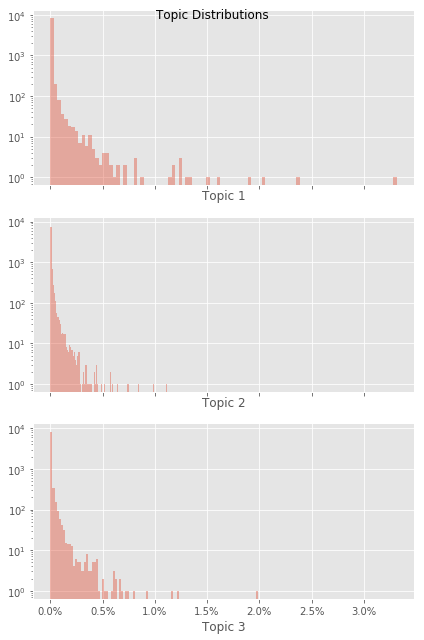

In [31]:
fig, axes = plt.subplots(nrows=n_components,sharey=True,sharex=True,figsize=(6,9))

for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob,ax=axes[i],bins=100,kde=False,norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x,_:'{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

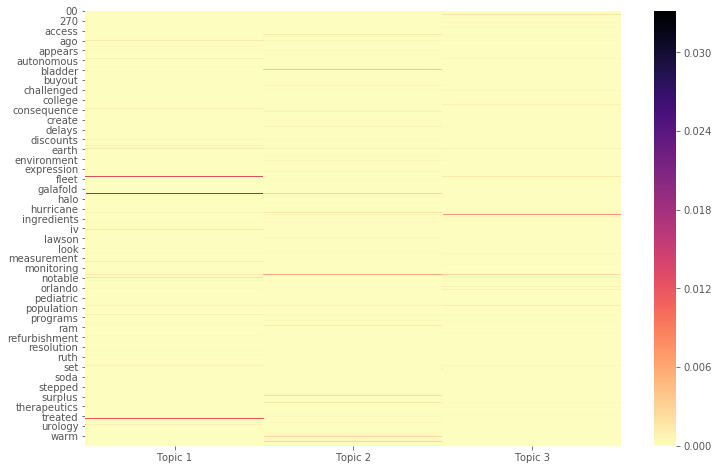

In [32]:
plt.figure(figsize=(12,8))
sns.heatmap(topics, cmap='magma_r');

### Word Cloud (3)

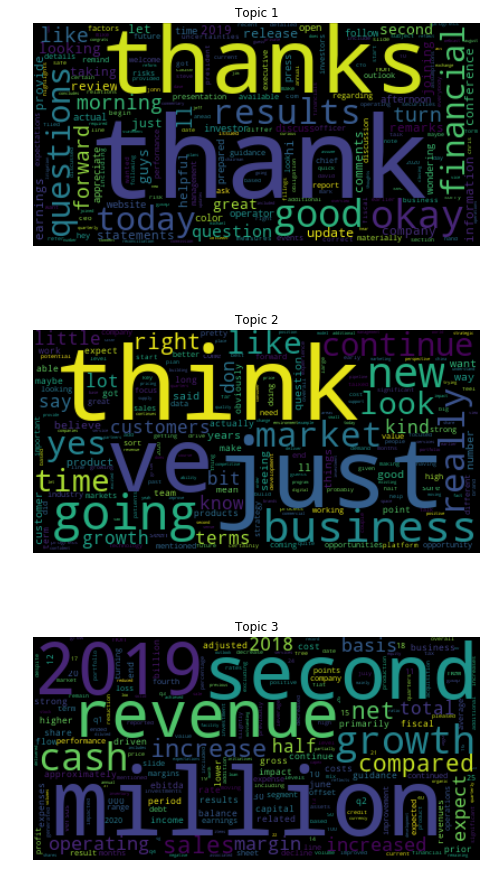

In [33]:
w = WordCloud()
fig, axes = plt.subplots(nrows= n_components, figsize=(8,16))
axes = axes.flatten()
for t,(topic,freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w,interpolation='bilinear')
    axes[t].set_title(topic, fontsize=12)
    axes[t].axis('off')

### Predictions (3)

In [34]:
train_preds = lda_opt.transform(train_dtm)
train_preds.shape

(124813, 3)

In [35]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels)

In [36]:
train_eval.head()

,Topic 1,Topic 2,Topic 3
0,0.44,0.11,0.44
1,0.52,0.37,0.11
2,0.01,0.01,0.97
3,0.09,0.89,0.02
4,0.02,0.91,0.07


In [37]:
test_preds = lda_opt.transform(test_dtm)
test_preds.shape

(5000, 3)

In [38]:
test_eval = pd.DataFrame(test_preds, columns=topic_labels)
test_eval.head()

,Topic 1,Topic 2,Topic 3
0,0.01,0.85,0.14
1,0.01,0.70,0.29
2,0.15,0.38,0.46
3,0.13,0.85,0.02
4,0.02,0.96,0.02


### Perplexity (3)

In [39]:
lda_opt.perplexity(train_dtm)

1992.260486767759

In [40]:
lda_opt.perplexity(test_dtm)

3208.285705888594

### Cluster Graphs using PyLDAvis.prepare (3)

In [41]:
prepare(lda_opt, test_dtm, vectorizer)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
1     -0.12  0.19       1        1 57.87
2     -0.19 -0.16       2        1 29.65
0      0.31 -0.02       3        1 12.48, topic_info=     Category   Freq          Term  Total  loglift  logprob
8065  Default 484.00         thank 484.00    30.00    30.00
5163  Default 690.00       million 690.00    29.00    29.00
8068  Default 344.00        thanks 344.00    28.00    28.00
3740  Default 491.00          good 491.00    27.00    27.00
5547  Default 299.00          okay 299.00    26.00    26.00
4752  Default 478.00          like 478.00    25.00    25.00
6914  Default 357.00       results 357.00    24.00    24.00
8158  Default 301.00         today 301.00    23.00    23.00
4810  Default 394.00            ll 394.00    22.00    22.00
6427  Default 351.00      question 351.00    21.00    21.00
3528  Default 322.00       forward 322.00    20.00    20.00
147   Default 501.00          2019 501.00    19.00    19.00
8088  Default 758.00         think 758.00    18.00    18.00
6429  Default 198.00     questions 198.00    17.00    17.00
7187  Default 632.00        second 632.00    16.00    16.00
3392  Default 250.00     financial 250.00    15.00    15.00
5263  Default 182.00       morning 182.00    14.00    14.00
8336  Default 180.00          turn 180.00    13.00    13.00
4517  Default 762.00          just 762.00    12.00    12.00
3777  Default 250.00         great 250.00    11.00    11.00
6941  Default 388.00       revenue 388.00    10.00    10.00
1536  Default 261.00          cash 261.00     9.00     9.00
8550  Default 575.00            ve 575.00     8.00     8.00
4850  Default 269.00       looking 269.00     7.00     7.00
1895  Default 241.00      compared 241.00     6.00     6.00
5382  Default 232.00           net 232.00     5.00     5.00
3828  Default 126.00          guys 126.00     4.00     4.00
4169  Default 286.00      increase 286.00     3.00     3.00
4170  Default 209.00     increased 209.00     2.00     2.00
146   Default 217.00          2018 217.00     1.00     1.00
...       ...    ...           ...    ...      ...      ...
3922   Topic3  67.37       helpful  67.40     2.08    -5.38
586    Topic3  59.92     afternoon  59.95     2.08    -5.50
2632   Topic3  61.13       discuss  61.16     2.08    -5.48
8718   Topic3  57.08       website  57.11     2.08    -5.55
478    Topic3  58.12        actual  58.15     2.08    -5.53
827    Topic3  56.87    appreciate  56.90     2.08    -5.55
4398   Topic3  57.59      investor  57.62     2.08    -5.54
6144   Topic3  58.82      prepared  58.85     2.08    -5.52
1669   Topic3  52.48         chief  52.50     2.08    -5.63
5528   Topic3  51.93       officer  51.96     2.08    -5.64
6156   Topic3  54.78  presentation  54.80     2.08    -5.59
8801   Topic3  55.32     wondering  55.35     2.08    -5.58
3828   Topic3 126.52          guys 126.68     2.08    -4.75
3392   Topic3 192.36     financial 250.61     1.82    -4.33
8158   Topic3 219.96         today 301.79     1.76    -4.20
6914   Topic3 236.06       results 357.82     1.67    -4.13
3740   Topic3 277.29          good 491.03     1.51    -3.97
3528   Topic3 172.61       forward 322.36     1.46    -4.44
6427   Topic3 169.69      question 351.16     1.35    -4.46
4810   Topic3 174.11            ll 394.03     1.26    -4.43
4752   Topic3 179.54          like 478.94     1.10    -4.40
3777   Topic3 121.08         great 250.16     1.36    -4.79
4850   Topic3 118.37       looking 269.56     1.26    -4.82
7954   Topic3  80.53        taking 134.28     1.57    -5.20
7187   Topic3 121.15        second 632.22     0.43    -4.79
1887   Topic3  96.18       company 312.92     0.90    -5.02
147    Topic3  96.19          2019 501.13     0.43    -5.02
6330   Topic3  81.25       provide 168.69     1.35    -5.19
4517   Topic3  88.60          just 762.53    -0.07    -5.11
2827   Topic3  78.53      earnings 159.39     1.37    -5.23

[185 rows x 6 columns], token_t

## Results:

According to the results of perplexities, the model with 4 topics have the lowest training perplexity.

The cluster graphs using PyLDAvis package shows that the 4-topic model can well seperate the documents of the test data. However, the word cloud is not
showing obvious topic names as clear as in problem 1 for training data. This can be because that in this problem for the large sample size, we are using only single tokens to make the model fit faster, so the model here in problem 2 has much less features than the model in problem 1. On the other hand, more work can be down on setting up the max_df and min_df in the CountVectorizer() function to filter out meaningless words such as "just", "thanks", "think" to improve the model performance.

Therefore, it becomes less convincing here that the topics make sense as a way to cluster the documents. We can say the documents can be clustered into 4 main clusters but with unclear topic names in this case, at least for this unoptimized model shown as above.

(Note: the computer suddenly shuts down when running the 3-topic model, so I restart it and run the 3-topic model again using 50 max_iters. The relative value of the perplexity is still less than the model with 5 topics, and larger than the the model with 4 topics.)